<img src="./imgs/mbit-logo.png" align="right" style="float" width="55">
<font color="#CA3532"><h1 align="left">EJERCICIO: APRENDIZAJE SUPERVISADO CON PYTHON</h1></font>
<font color="#CA3532"><h2 align="left">Máster en Big Data, Cloud & Analytics 2019-2020</h2></font>
<font color="#CA3532"><h3 align="left">Carlos Alfonsel Jaén <a>carlos.alfonsel@mbitschool.com</a></h4></font>
</br>
</br>
</br>
<font color="#6E6E6E"><h3 align="left">ÍNDICE:</h2></font>
</br>
<font color="#6E6E6E"><h4 align="left">0. Ajustes Iniciales del Notebook.</h2></font>
<font color="#6E6E6E"><h4 align="left">1. Importación de Librerías y Definición de Funciones Auxiliares.</h2></font>
<font color="#6E6E6E"><h4 align="left">2. Análisis Exploratorio del Dataset: Auditoría Datos, Missing Values y Correlación.</h2></font>
<font color="#6E6E6E"><h4 align="left">3. Modelos Aprendizaje Supervisado: Decision Trees, Random Forest, Gradient-Boosted Trees (GBT), k-NN, SVM y Redes Neuronales (ANN).</h2></font>
<font color="#6E6E6E"><h4 align="left">4. Resumen: Comparativa entre Modelos de Aprendizaje Supervisado.</h2></font>

## 0. AJUSTES INICIALES DEL NOTEBOOK

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE FUNCIONES AUXILIARES

A continuación, importamos las librerías de *Machine Learning* necesarias y definimos la función encargada de hacer ajuste de parámetros de un determinado algoritmo, de acuerdo a los parámetros pasados como argumento, y que mostrará un informe con los resultados obtenidos. Esta función la usaremos en varios puntos del documento para automatizar el proceso de ajuste de parámetros.

In [2]:
# Gestión de warnings: desactiva los warnings de tipo Deprecation para evitar que algunas bibliotecas que aún usen características de 
# versiones anteriores de scikit-learn emitan una gran cantidad de mensajes que pueda hacer muy difícil de seguir la traza de los algoritmos 
# y sus resultados.
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = ConvergenceWarning)

# Paquetes de manipulación de datos y creación de gráficos:
%matplotlib inline
import pandas as pd 
import numpy as np
import scipy

# Paquetes de visualización:
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas nativas de datasets:
from sklearn                       import datasets
from sklearn.datasets              import load_iris

# Utilidades de la librería de sklearn necesarias para técnicas de división de muestras (train/val/test):
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedKFold
from sklearn.model_selection       import StratifiedKFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import LeaveOneOut
from sklearn.model_selection       import LeavePOut
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import cross_validate

# Modelos de aprendizaje automático de la librería sklearn:
from sklearn                       import svm
from sklearn                       import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import GradientBoostingClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.naive_bayes           import GaussianNB
from sklearn.naive_bayes           import MultinomialNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.svm                   import SVC

# Métricas:
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import recall_score

# Librería de preprocesado:
from sklearn                       import preprocessing

# Librería de pipeline:
from sklearn.pipeline              import make_pipeline

# Librerías para ajuste de parámetros:
from sklearn.model_selection       import GridSearchCV
from sklearn.model_selection       import RandomizedSearchCV

# Función de ajuste de parámetros:
def doGridSearch(model, grid, scores, X_train, y_train, X_test, y_test, columns, indices):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf=GridSearchCV(model, grid, cv=10, scoring='%s' % score, iid=False)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()

        means=clf.cv_results_['mean_test_score']
        stds =clf.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

        conf=pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=columns,
            index  =indices
        )
        print(conf)
        
        return clf.best_estimator_

C:\Users\calfo\Anaconda3\envs\env_ml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2. ANÁLISIS EXPLORATORIO DEL CONJUNTO DE DATOS: AUDITORÍA, MISSING VALUES y CORRELACIÓN.

Se precisa un análisis preliminar del dataset "datos_train.csv" para determinar si:

- Existen variables que haya que descartar por ser identificadores o que no aporten información útil para resolver el problema.
- Existen variables con demasiados valores nulos (missing values) como para poder ser utilizadas.
- Existen variables con valores en distintos órdenes de magnitud, circunstancia que podría afectar al rendimiento de determinados modelos (normalización y estandarización).

### 2.1. PREPARACIÓN DATASET: AUDITORÍA DE DATOS.

In [3]:
# Importación de fichero CSV, categorizando algunas variables y cambiando las de valor "yes/no" a int64 (dicotómicas):
df_classe = pd.read_csv('./data/datos_train.csv')

# Hacemos una copia del dataframe para optimizar código:
df_test1 = df_classe.copy()

# Renombramos como TARGET la variable objetivo "classe":
df_test1 = pd.DataFrame(df_test1.rename(columns={'classe':'TARGET'}))
df_test1.head(5)

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,TARGET
0,carlitos,1323084231,788290,05/12/2011 11:23,1.41,8.07,-94.4,3,NaN,NaN,...,0.03,0.00,-0.02,192,203,-215,-17,654.0,476.0,A
1,carlitos,1323084231,808298,05/12/2011 11:23,1.41,8.07,-94.4,3,NaN,NaN,...,0.02,0.00,-0.02,192,203,-216,-18,661.0,473.0,A
2,carlitos,1323084231,820366,05/12/2011 11:23,1.42,8.07,-94.4,3,NaN,NaN,...,0.03,-0.02,0.00,196,204,-213,-18,658.0,469.0,A
3,carlitos,1323084232,120339,05/12/2011 11:23,1.48,8.05,-94.4,3,NaN,NaN,...,0.02,-0.02,0.00,189,206,-214,-16,658.0,469.0,A
4,carlitos,1323084232,196328,05/12/2011 11:23,1.48,8.07,-94.4,3,NaN,NaN,...,0.02,0.00,-0.02,189,206,-214,-17,655.0,473.0,A


In [4]:
# Vemos la estructura del dataframe:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19622 entries, 0 to 19621
Columns: 157 entries, user_name to TARGET
dtypes: float64(127), int64(27), object(3)
memory usage: 23.5+ MB


In [5]:
# Obtenemos unas estadísticas básicas de las variables numéricas (tipo INT64 y FLOAT64) del dataset:
df_test1.describe()

,raw_timestamp_part_1,raw_timestamp_part_2,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,kurtosis_yaw_belt,skewness_roll_belt,...,var_yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
count,1.962200e+04,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,396.000000,374.000000,0.0,397.000000,...,406.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000
mean,1.322827e+09,500656.144277,64.407197,0.305283,-11.205061,11.312608,-0.220248,4.334199,NaN,-0.026096,...,4639.849068,0.157951,0.075175,0.151245,-61.651819,163.655896,-55.291917,-312.575884,380.116445,393.613745
std,2.049277e+05,288222.879958,62.750255,22.351242,95.193926,7.742309,2.924547,11.582812,NaN,0.916383,...,7284.972361,0.648618,3.100725,1.754483,180.593687,200.130082,138.396947,346.958482,509.373742,369.268747
min,1.322490e+09,294.000000,-28.900000,-55.800000,-180.000000,0.000000,-2.121212,-2.190476,NaN,-5.744563,...,0.000000,-22.000000,-7.020000,-8.090000,-498.000000,-632.000000,-446.000000,-1280.000000,-896.000000,-973.000000
25%,1.322673e+09,252912.250000,1.100000,1.760000,-88.300000,3.000000,-1.329350,-1.106648,NaN,-0.443717,...,0.274550,-0.220000,-1.460000,-0.180000,-178.000000,57.000000,-182.000000,-616.000000,2.000000,191.000000
50%,1.322833e+09,496380.000000,113.000000,5.280000,-13.000000,17.000000,-0.899278,-0.150950,NaN,0.000000,...,612.214225,0.050000,0.030000,0.080000,-57.000000,201.000000,-39.000000,-378.000000,591.000000,511.000000
75%,1.323084e+09,751890.750000,123.000000,14.900000,12.900000,18.000000,-0.219149,3.177705,NaN,0.416939,...,7368.414252,0.560000,1.620000,0.490000,76.000000,312.000000,26.000000,-73.000000,737.000000,653.000000
max,1.323095e+09,998801.000000,162.000000,60.300000,179.000000,29.000000,33.000000,58.000000,NaN,3.595369,...,39009.333330,3.970000,311.000000,231.000000,477.000000,923.000000,291.000000,672.000000,1480.000000,1090.000000


In [6]:
# Vemos si existen valores duplicados:
df_test1.T.duplicated()
print('Número de registros duplicados del dataset: ', df_test1.duplicated().sum())

Número de registros duplicados del dataset:  0


In [7]:
# Comprobamos si existen variables con un único valor:
df_test1.apply(pd.Series.nunique) == 1

user_name               False
raw_timestamp_part_1    False
raw_timestamp_part_2    False
cvtd_timestamp          False
roll_belt               False
                        ...  
accel_forearm_z         False
magnet_forearm_x        False
magnet_forearm_y        False
magnet_forearm_z        False
TARGET                  False
Length: 157, dtype: bool

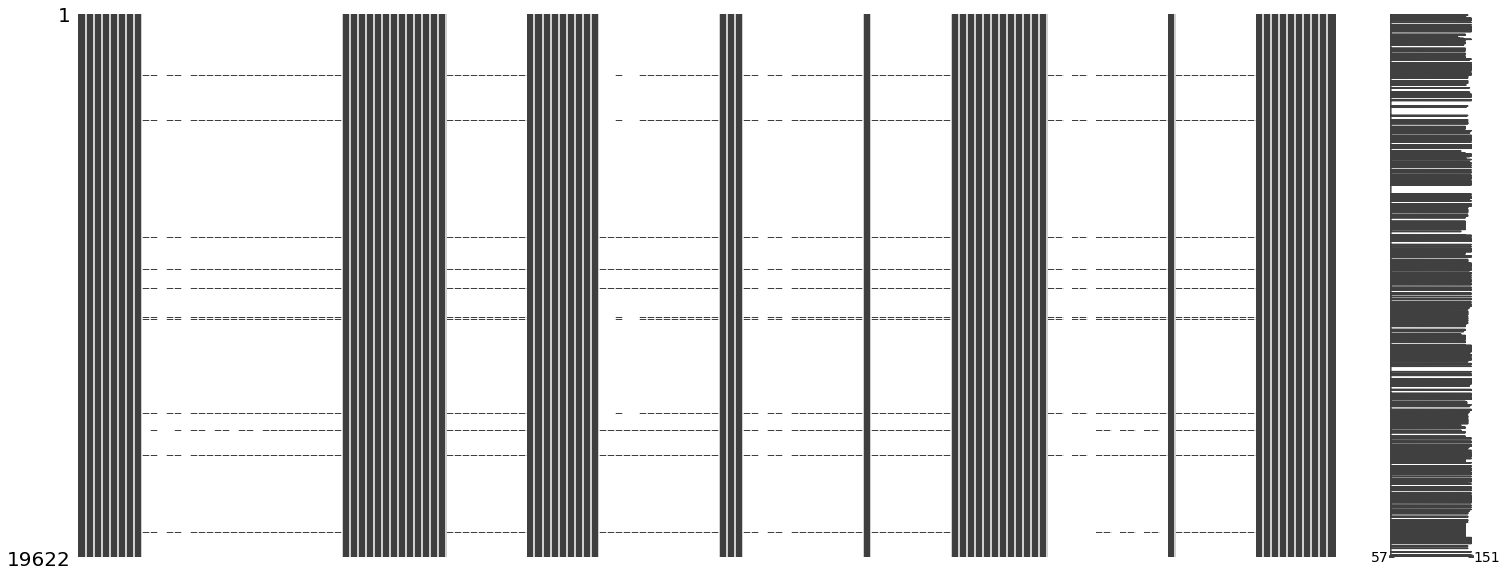

In [8]:
# PARA LA VISUALIZACIÓN DE MISSING VALUES:
import missingno as msno

# Vemos si el dataset tiene Missing Values:
df_test1.isnull().sum()

# Lo representamos gráficamente para verlo mejor:
msno.matrix(df_test1)
plt.show()

<img src="./imgs/warning.jpg" align="left" style="float" width="40">
<font color="red"><h3>&nbsp;&nbsp;COMPROBAMOS QUE UN NÚMERO ELEVADO DE VARIABLES TIENEN TODOS SUS VALORES IGUALES A NaN.</h3></font>

### 2.2. PREPARACIÓN DATASET: ELIMINACIÓN DE VARIABLES CON VALORES NULOS.

In [9]:
# Metemos en una lista todas aquellas variables cuyos valores son nulos:
varsToBeErased = ["user_name","raw_timestamp_part_1","raw_timestamp_part_2","cvtd_timestamp", 
                  "kurtosis_roll_belt","kurtosis_picth_belt","kurtosis_yaw_belt",
                  "kurtosis_roll_belt","kurtosis_picth_belt","kurtosis_yaw_belt",
                  "skewness_roll_belt","skewness_roll_belt.1","skewness_yaw_belt",
                  "max_roll_belt","max_picth_belt","max_yaw_belt","min_roll_belt",
                  "min_pitch_belt","min_yaw_belt","amplitude_roll_belt","amplitude_pitch_belt",
                  "amplitude_yaw_belt","var_total_accel_belt","avg_roll_belt","stddev_roll_belt",
                  "var_roll_belt","avg_pitch_belt","stddev_pitch_belt","var_pitch_belt","avg_yaw_belt",
                  "stddev_yaw_belt","var_yaw_belt","var_accel_arm","avg_roll_arm","stddev_roll_arm","var_roll_arm",
                  "avg_pitch_arm","stddev_pitch_arm","var_pitch_arm","avg_yaw_arm","stddev_yaw_arm","var_yaw_arm",
                  "kurtosis_roll_arm","kurtosis_picth_arm","kurtosis_yaw_arm","skewness_roll_arm","skewness_pitch_arm",
                  "skewness_yaw_arm","max_roll_arm","max_picth_arm","max_yaw_arm","min_roll_arm","min_pitch_arm",
                  "min_yaw_arm","amplitude_roll_arm","amplitude_pitch_arm","amplitude_yaw_arm","kurtosis_roll_dumbbell",
                  "kurtosis_picth_dumbbell","kurtosis_yaw_dumbbell","skewness_roll_dumbbell","skewness_pitch_dumbbell",
                  "skewness_yaw_dumbbell","max_roll_dumbbell","max_picth_dumbbell","max_yaw_dumbbell","min_roll_dumbbell",
                  "min_pitch_dumbbell","min_yaw_dumbbell","amplitude_roll_dumbbell","amplitude_pitch_dumbbell",
                  "amplitude_yaw_dumbbell","var_accel_dumbbell","avg_roll_dumbbell","stddev_roll_dumbbell",
                  "var_roll_dumbbell","avg_pitch_dumbbell","stddev_pitch_dumbbell","var_pitch_dumbbell","avg_yaw_dumbbell",
                  "stddev_yaw_dumbbell","var_yaw_dumbbell","kurtosis_roll_forearm","kurtosis_picth_forearm",
                  "kurtosis_yaw_forearm","skewness_roll_forearm","skewness_pitch_forearm","skewness_yaw_forearm",
                  "max_roll_forearm","max_picth_forearm","max_yaw_forearm","min_roll_forearm","min_pitch_forearm",
                  "min_yaw_forearm","amplitude_roll_forearm","amplitude_pitch_forearm","amplitude_yaw_forearm",
                  "var_accel_forearm","avg_roll_forearm","stddev_roll_forearm","var_roll_forearm","avg_pitch_forearm",
                  "stddev_pitch_forearm","var_pitch_forearm","avg_yaw_forearm","stddev_yaw_forearm","var_yaw_forearm"]

# Eliminamos del dataset las variables de la lista anterior:
df_test1 = df_test1.drop(varsToBeErased, axis = 1)
df_test1.head(5)

,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,...,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,TARGET
0,1.41,8.07,-94.4,3,0.00,0.00,-0.02,-21,4,22,...,0.03,0.00,-0.02,192,203,-215,-17,654.0,476.0,A
1,1.41,8.07,-94.4,3,0.02,0.00,-0.02,-22,4,22,...,0.02,0.00,-0.02,192,203,-216,-18,661.0,473.0,A
2,1.42,8.07,-94.4,3,0.00,0.00,-0.02,-20,5,23,...,0.03,-0.02,0.00,196,204,-213,-18,658.0,469.0,A
3,1.48,8.05,-94.4,3,0.02,0.00,-0.03,-22,3,21,...,0.02,-0.02,0.00,189,206,-214,-16,658.0,469.0,A
4,1.48,8.07,-94.4,3,0.02,0.02,-0.02,-21,2,24,...,0.02,0.00,-0.02,189,206,-214,-17,655.0,473.0,A


In [10]:
# Comprobamos que ninguna de las variables "supervivientes" tiene valores nulos:
df_test1.isnull().sum()

roll_belt               0
pitch_belt              0
yaw_belt                0
total_accel_belt        0
gyros_belt_x            0
gyros_belt_y            0
gyros_belt_z            0
accel_belt_x            0
accel_belt_y            0
accel_belt_z            0
magnet_belt_x           0
magnet_belt_y           0
magnet_belt_z           0
roll_arm                0
pitch_arm               0
yaw_arm                 0
total_accel_arm         0
gyros_arm_x             0
gyros_arm_y             0
gyros_arm_z             0
accel_arm_x             0
accel_arm_y             0
accel_arm_z             0
magnet_arm_x            0
magnet_arm_y            0
magnet_arm_z            0
roll_dumbbell           0
pitch_dumbbell          0
yaw_dumbbell            0
total_accel_dumbbell    0
gyros_dumbbell_x        0
gyros_dumbbell_y        0
gyros_dumbbell_z        0
accel_dumbbell_x        0
accel_dumbbell_y        0
accel_dumbbell_z        0
magnet_dumbbell_x       0
magnet_dumbbell_y       0
magnet_dumbb

In [11]:
# Información del dataset resultante una vez ejecutada la limpieza de missing values:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19622 entries, 0 to 19621
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   roll_belt             19622 non-null  float64
 1   pitch_belt            19622 non-null  float64
 2   yaw_belt              19622 non-null  float64
 3   total_accel_belt      19622 non-null  int64  
 4   gyros_belt_x          19622 non-null  float64
 5   gyros_belt_y          19622 non-null  float64
 6   gyros_belt_z          19622 non-null  float64
 7   accel_belt_x          19622 non-null  int64  
 8   accel_belt_y          19622 non-null  int64  
 9   accel_belt_z          19622 non-null  int64  
 10  magnet_belt_x         19622 non-null  int64  
 11  magnet_belt_y         19622 non-null  int64  
 12  magnet_belt_z         19622 non-null  int64  
 13  roll_arm              19622 non-null  float64
 14  pitch_arm             19622 non-null  float64
 15  yaw_arm            

In [12]:
# Estadísticas básicas del dataset una vez eliminados los missing values:
df_test1.describe()

,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,...,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
count,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,...,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000
mean,64.407197,0.305283,-11.205061,11.312608,-0.005592,0.039588,-0.130538,-5.594690,30.154877,-72.593619,...,34.715320,0.157951,0.075175,0.151245,-61.651819,163.655896,-55.291917,-312.575884,380.116445,393.613745
std,62.750255,22.351242,95.193926,7.742309,0.207329,0.078236,0.241321,29.644785,28.577835,100.446740,...,10.055956,0.648618,3.100725,1.754483,180.593687,200.130082,138.396947,346.958482,509.373742,369.268747
min,-28.900000,-55.800000,-180.000000,0.000000,-1.040000,-0.640000,-1.460000,-120.000000,-69.000000,-275.000000,...,0.000000,-22.000000,-7.020000,-8.090000,-498.000000,-632.000000,-446.000000,-1280.000000,-896.000000,-973.000000
25%,1.100000,1.760000,-88.300000,3.000000,-0.030000,0.000000,-0.200000,-21.000000,3.000000,-162.000000,...,29.000000,-0.220000,-1.460000,-0.180000,-178.000000,57.000000,-182.000000,-616.000000,2.000000,191.000000
50%,113.000000,5.280000,-13.000000,17.000000,0.030000,0.020000,-0.100000,-15.000000,35.000000,-152.000000,...,36.000000,0.050000,0.030000,0.080000,-57.000000,201.000000,-39.000000,-378.000000,591.000000,511.000000
75%,123.000000,14.900000,12.900000,18.000000,0.110000,0.110000,-0.020000,-5.000000,61.000000,27.000000,...,41.000000,0.560000,1.620000,0.490000,76.000000,312.000000,26.000000,-73.000000,737.000000,653.000000
max,162.000000,60.300000,179.000000,29.000000,2.220000,0.640000,1.620000,85.000000,164.000000,105.000000,...,108.000000,3.970000,311.000000,231.000000,477.000000,923.000000,291.000000,672.000000,1480.000000,1090.000000


### 2.3. PREPARACIÓN DATASET: ELIMINACIÓN DE VARIABLES CON VALORES ALTOS DE CORRELACIÓN ENTRE ELLAS.

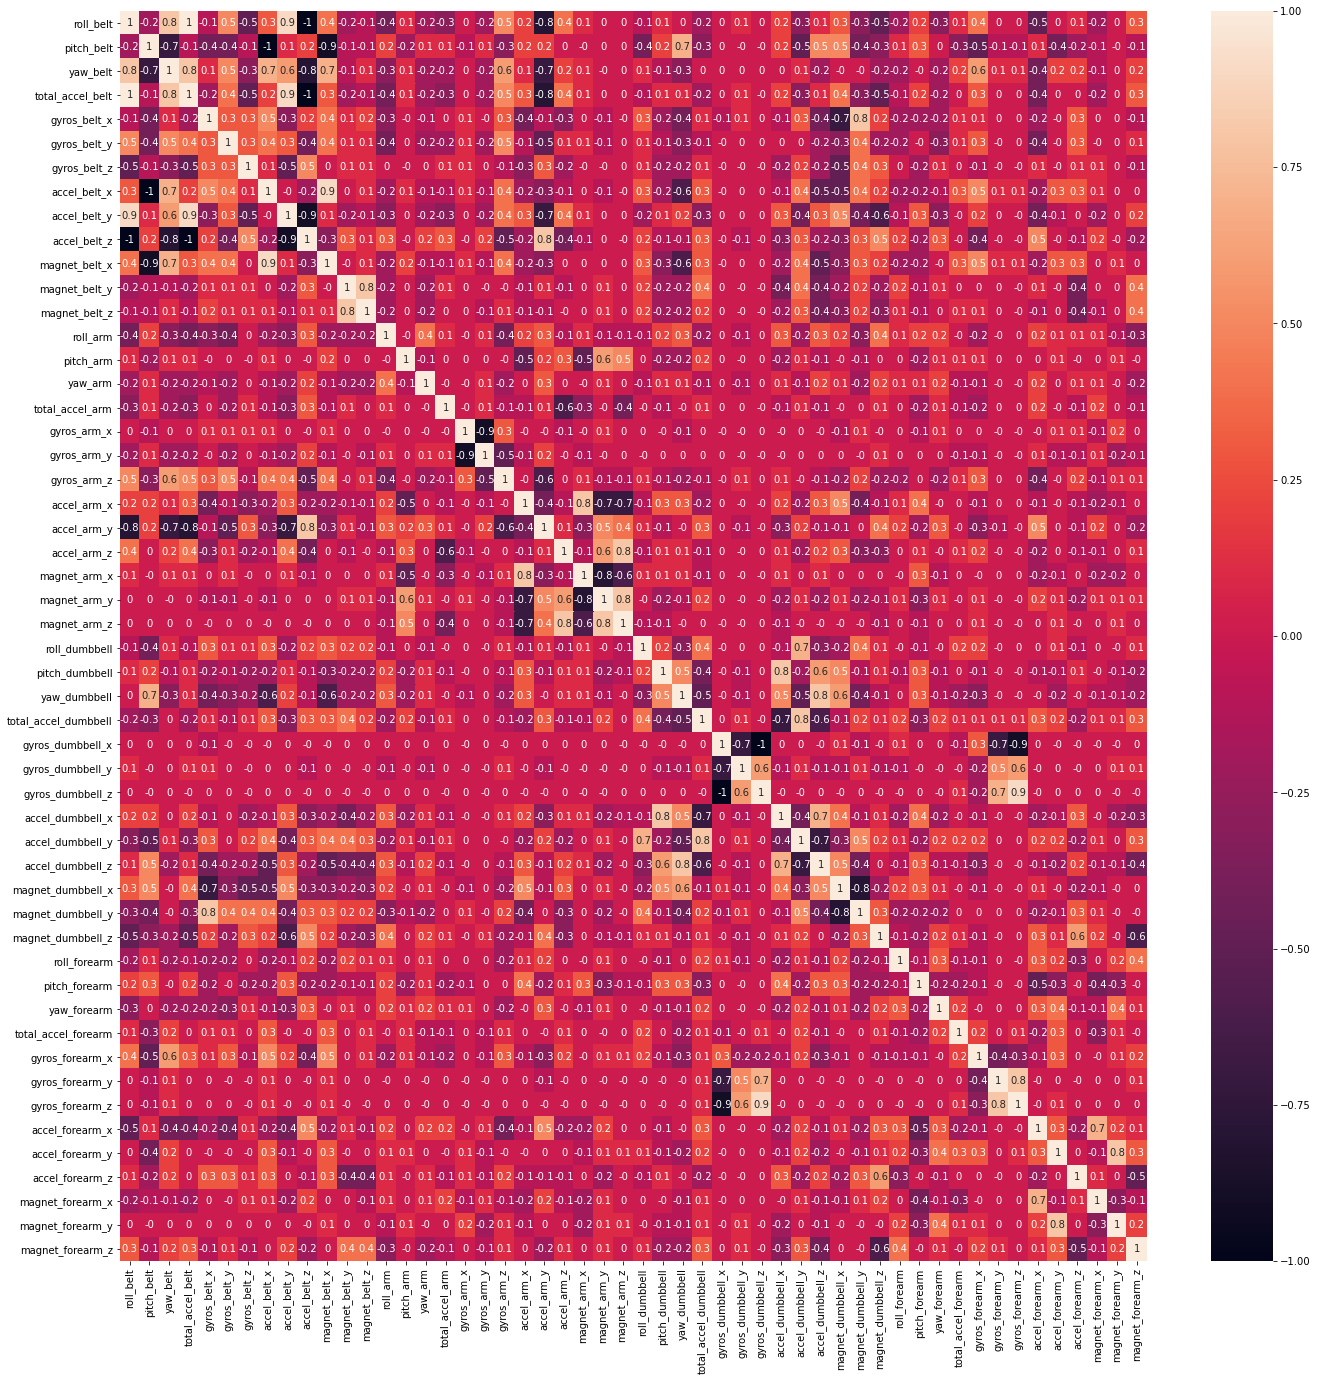

In [13]:
# Obtenemos la matriz de correlación de las variables que nos quedan una vez limpiado el dataset de missing values:
dfCorr1 = df_test1.copy()
correlation_matrix = dfCorr1.corr().round(1)
plt.subplots(figsize = (23,23))
cor = sns.heatmap(data = correlation_matrix, annot = True)

In [14]:
# Metemos en una lista aquellas variables cuyos valores de correlación superan un umbral (0.75):
varsToBeErasedCorr = ["accel_belt_x","accel_belt_y","accel_belt_z","roll_belt",
                      "pitch_belt","total_accel_belt","accel_dumbbell_x","accel_dumbbell_y",
                      "accel_dumbbell_z","magnet_dumbbell_x","magnet_dumbbell_y","accel_arm_x",
                      "accel_arm_z","magnet_arm_y","magnet_belt_y","accel_forearm_y",
                      "gyros_arm_y","gyros_forearm_y","gyros_forearm_z","gyros_dumbbell_x"]

# Eliminamos del dataset las variables con valores de correlación superiores a 0.75:
df_test2 = df_test1.drop(varsToBeErasedCorr, axis = 1)
df_test2.head(5)

,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,magnet_belt_x,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,...,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,accel_forearm_x,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,TARGET
0,-94.4,0.00,0.00,-0.02,-3,-313,-128.0,22.5,-161.0,34,...,-63.9,-153.0,36,0.03,192,-215,-17,654.0,476.0,A
1,-94.4,0.02,0.00,-0.02,-7,-311,-128.0,22.5,-161.0,34,...,-63.9,-153.0,36,0.02,192,-216,-18,661.0,473.0,A
2,-94.4,0.00,0.00,-0.02,-2,-305,-128.0,22.5,-161.0,34,...,-63.9,-152.0,36,0.03,196,-213,-18,658.0,469.0,A
3,-94.4,0.02,0.00,-0.03,-6,-310,-128.0,22.1,-161.0,34,...,-63.9,-152.0,36,0.02,189,-214,-16,658.0,469.0,A
4,-94.4,0.02,0.02,-0.02,-6,-302,-128.0,22.1,-161.0,34,...,-63.9,-152.0,36,0.02,189,-214,-17,655.0,473.0,A


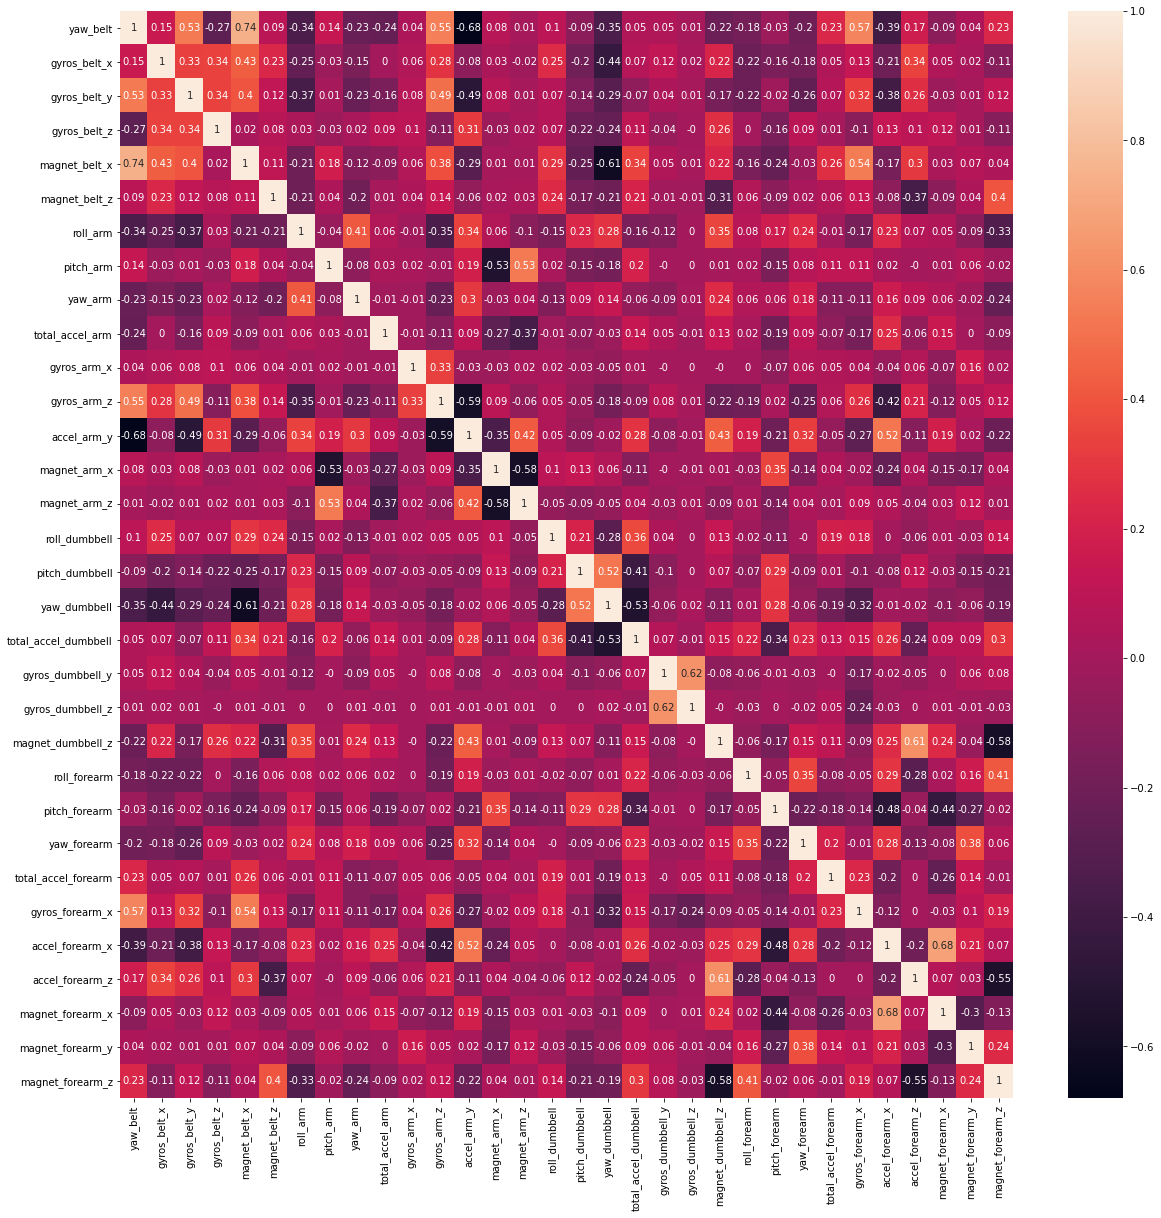

In [15]:
# Obtenemos la nueva matriz de correlación de nuestro dataset preprocesado, con 32 VARIABLES PREDICTORAS:
dfCorr2 = df_test2.copy()
correlation_matrix = dfCorr2.corr().round(2)
plt.subplots(figsize = (20,20))
cor = sns.heatmap(data = correlation_matrix, annot = True)

## 3. ENTRENAMIENTO/VALIDACIÓN DEL DATASET PREPROCESADO CON 32 PREDICTORES

In [16]:
df1 = df_test1.copy() # dataset con 52 variables
df2 = df_test2.copy() # dataset con 32 variables

# DATASET CON 52 VARIABLES (ELIMINADAS LAS QUE TENÍAN VALORES NaN)
#df = df1.copy()
# DATASET CON 32 VARIABLES (ELIMINADAS ADEMÁS LAS QUE MUESTRAN VALORES ALTOS DE CORRELACIÓN/COLINEARIDAD ENTRE ELLAS)
df  = df2.copy()

**ALGORITMOS UTILIZADOS EN APRENDIZAJE SUPERVISADO**:

1. ÁRBOLES DE DECISIÓN.
2. RANDOM FOREST.
3. GRADIENT-BOOSTED TREES.
4. k-NN (*k-NEAREST NEIGHBORS*).
5. SVM (*SUPPORT VECTOR MACHINE*).
6. ANN (*ARTIFICIAL NEURAL NETWORK*).

**NOTA**: en este apartado se verá que los resultados de precisión (*accuracy*) obtenidos con un algoritmo *Naive-Bayes* apenas superan el 50%, por lo que se considera que no es adecuado para entrenar este conjunto de datos.

In [17]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# DIVIDIMOS EL DATASET:
X = df.iloc[:,range(0,32)]
Y = df.iloc[:,32]

**NORMALIZACIÓN DE VALORES (VARIABLES PREDICTORAS)**:

Como existen variables con valores en distintos órdenes de magnitud, circunstancia que puede afectar al rendimiento de determinados modelos, vamos a normalizar los valores de los registros utilizando la función *MinMaxScaler()*.

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# NORMALIZAMOS LOS VALORES DE LAS VARIABLES PREDICTORAS:
scaler = MinMaxScaler()
#scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)

In [19]:
# PARA UTILIZAR EL DATASET CON VALORES NORMALIZADOS:
X = scaled_X.copy()

# OBTENEMOS LOS SUBCONJUNTOS DE ENTRENAMIENTO Y VALIDACIÓN:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [20]:
X_train.head()

,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,magnet_belt_x,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,...,roll_forearm,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,accel_forearm_x,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
12427,0.510613,0.349693,0.585938,0.425325,0.145251,0.323144,0.401389,0.476819,0.384444,0.123077,...,0.404722,0.723352,0.144444,0.342593,0.863304,0.140513,0.672999,0.303791,0.555976,0.750364
5953,0.484708,0.141104,0.515625,0.305195,0.044693,0.284934,0.819444,0.606317,0.665000,0.323077,...,0.027778,0.738755,0.202778,0.259259,0.819407,0.447179,0.328358,0.548156,0.156566,0.559864
6034,0.253482,0.312883,0.515625,0.467532,0.167598,0.216157,0.734722,0.477439,0.683056,0.369231,...,0.988889,0.563771,0.788889,0.333333,0.844051,0.444103,0.896879,0.347848,0.844276,0.230247
12944,0.241226,0.309816,0.515625,0.480519,0.100559,0.365721,0.639167,0.453299,0.676944,0.230769,...,0.058333,0.789895,0.088889,0.250000,0.839045,0.318974,0.345997,0.361168,0.336279,0.690257
14930,0.961003,0.377301,0.585938,0.431818,0.394786,0.346070,0.483528,0.434856,0.426111,0.153846,...,0.500000,0.446704,0.500000,0.425926,0.910281,0.508718,0.529172,0.590164,0.694444,0.715948


### 3.1. ÁRBOLES DE DECISIÓN (DecisionTreeClassifier)

In [21]:
# ÁRBOLES DE DECISIÓN:

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo y entrenamiento:
tree = DecisionTreeClassifier(max_depth = 15, min_samples_split = 5)
tree.fit(X_train, y_train)

# Validación contra el conjunto de test:
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.97      0.97      0.97      1711
           B       0.91      0.88      0.90      1148
           C       0.86      0.91      0.88      1023
           D       0.89      0.90      0.89       952
           E       0.96      0.93      0.95      1053

    accuracy                           0.92      5887
   macro avg       0.92      0.92      0.92      5887
weighted avg       0.92      0.92      0.92      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1653           20            8           23            7
True B           29         1011           70           24           14
True C            5           46          926           36           10
True D           13           22           50          860            7
True E           12            9           23           27          982


In [22]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = tree.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = tree.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98      3869
           B       0.96      0.95      0.95      2649
           C       0.91      0.95      0.93      2399
           D       0.94      0.94      0.94      2264
           E       0.99      0.97      0.98      2554

    accuracy                           0.96     13735
   macro avg       0.96      0.96      0.96     13735
weighted avg       0.96      0.96      0.96     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.97      0.97      0.97      1711
           B       0.91      0.88      0.90      1148
           C       0.86      0.91      0.88      1023
           D       0.89      0.90      0.89       952
           E       0.96      0.93      0.95      1053

    accuracy                           0.92      5887
   macro avg       0.92      0.92      0.92      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,04.</h4></font>

In [23]:
# AJUSTE DE PARÁMETROS:
# max_depth: the maximum depth of the tree.

tuned_parameters = {'max_depth': [10, 15, 20, 25, 30]}

doGridSearch(RandomForestClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 25}

Grid scores on development set:

0.929 (+/-0.016) for {'max_depth': 10}
0.980 (+/-0.007) for {'max_depth': 15}
0.989 (+/-0.003) for {'max_depth': 20}
0.991 (+/-0.003) for {'max_depth': 25}
0.991 (+/-0.003) for {'max_depth': 30}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1711
           B       0.99      0.99      0.99      1148
           C       0.98      0.98      0.98      1023
           D       0.99      0.98      0.99       952
           E       1.00      1.00      1.00      1053

    accuracy                           0.99      5887
   macro avg       0.99      0.99      0.99      5887
weighted avg       0.99      0.99      0.99      5887


        Predicted A  Predicted B  Predi

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;AUMENTANDO LA PROFUNDIDAD DEL ÁRBOL SE PUEDE MEJORAR AÚN MÁS LA PRECISIÓN.</h4></font>

In [53]:
# REPRESENTACIÓN GRÁFICA DEL ÁRBOL (se exporta a un PDF):

%matplotlib inline

from sklearn import tree as t
import graphviz

dot_data = t.export_graphviz(tree, out_file = None, feature_names = X_test.columns, class_names = ["A", "B", "C", "D", "E"], 
                             filled = True, rounded = True, special_characters = True)  
graph = graphviz.Source(dot_data, filename = "./trees/DecisionTree")  
graph.render()

'./trees\\DecisionTree.pdf'

### 3.2. RANDOM FOREST (RandomForestClassifier)

In [25]:
# RANDOM FOREST:
from sklearn.ensemble import RandomForestClassifier

# Definición del modelo y entrenamiento:
rf = RandomForestClassifier(n_estimators = 4, random_state = 1)
rf.fit(X_train, y_train)

# Validación del modelo:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.97      1.00      0.98      1711
           B       0.95      0.95      0.95      1148
           C       0.93      0.95      0.94      1023
           D       0.96      0.93      0.94       952
           E       0.99      0.96      0.98      1053

    accuracy                           0.96      5887
   macro avg       0.96      0.96      0.96      5887
weighted avg       0.96      0.96      0.96      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1703            2            2            3            1
True B           25         1095           19            3            6
True C            5           36          968           12            2
True D           14           14           40          883            1
True E            3           11            9           18         1012


In [26]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = rf.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = rf.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.99      1.00      1.00      3869
           B       0.99      0.99      0.99      2649
           C       0.99      0.99      0.99      2399
           D       1.00      0.98      0.99      2264
           E       1.00      0.99      1.00      2554

    accuracy                           0.99     13735
   macro avg       0.99      0.99      0.99     13735
weighted avg       0.99      0.99      0.99     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.97      1.00      0.98      1711
           B       0.95      0.95      0.95      1148
           C       0.93      0.95      0.94      1023
           D       0.96      0.93      0.94       952
           E       0.99      0.96      0.98      1053

    accuracy                           0.96      5887
   macro avg       0.96      0.96      0.96      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,03.</h4></font>

In [27]:
# AJUSTE DE PARÁMETROS:
# max_depth   : the maximum depth of the tree.
# n_estimators: the number of trees in the forest.

tuned_parameters={'max_depth'   : [20, 25, 30],
                  'n_estimators': [ 4,  5,  6]}

doGridSearch(RandomForestClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 6}

Grid scores on development set:

0.951 (+/-0.013) for {'max_depth': 20, 'n_estimators': 4}
0.964 (+/-0.013) for {'max_depth': 20, 'n_estimators': 5}
0.970 (+/-0.012) for {'max_depth': 20, 'n_estimators': 6}
0.954 (+/-0.012) for {'max_depth': 25, 'n_estimators': 4}
0.967 (+/-0.006) for {'max_depth': 25, 'n_estimators': 5}
0.970 (+/-0.011) for {'max_depth': 25, 'n_estimators': 6}
0.956 (+/-0.012) for {'max_depth': 30, 'n_estimators': 4}
0.967 (+/-0.009) for {'max_depth': 30, 'n_estimators': 5}
0.971 (+/-0.010) for {'max_depth': 30, 'n_estimators': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1711
           B       0.96      0.97      0.97      1148
           C       0

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=6,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;AUMENTANDO EL NÚMERO DE ÁRBOLES Y SU PROFUNDIDAD SE PUEDE MEJORAR AÚN MÁS LA PRECISIÓN.</h4></font>

In [52]:
%matplotlib inline

from sklearn import tree as t
import graphviz

dot_data = t.export_graphviz(rf.estimators_[3], out_file = None, feature_names = X_test.columns, class_names=["A", "B", "C", "D", "E"], 
                             filled = True, rounded = True, special_characters = True)  
graph = graphviz.Source(dot_data, filename = "./trees/RandomForest")  
graph.render()

'./trees\\RandomForest.pdf'

### 3.3. GRADIENT-BOOSTED TREES (GradientBoostingClassifier)

In [29]:
# GRADIENT-BOOSTED TREES:
from sklearn.ensemble import GradientBoostingClassifier

# Definición del modelo y entrenamiento:
gbt = GradientBoostingClassifier(n_estimators = 50, random_state = 1)
gbt.fit(X_train, y_train)

# Validación del modelo:
y_pred = gbt.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.96      0.95      0.95      1711
           B       0.86      0.87      0.87      1148
           C       0.83      0.89      0.86      1023
           D       0.90      0.88      0.89       952
           E       0.97      0.94      0.95      1053

    accuracy                           0.91      5887
   macro avg       0.90      0.90      0.90      5887
weighted avg       0.91      0.91      0.91      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1623           22           18           42            6
True B           61          995           73           11            8
True C            0           87          911           18            7
True D           13           19           73          835           12
True E            2           28           18           20          985


In [30]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = gbt.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = gbt.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.96      0.96      0.96      3869
           B       0.90      0.88      0.89      2649
           C       0.86      0.92      0.89      2399
           D       0.92      0.91      0.92      2264
           E       0.98      0.93      0.96      2554

    accuracy                           0.93     13735
   macro avg       0.92      0.92      0.92     13735
weighted avg       0.93      0.93      0.93     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.96      0.95      0.95      1711
           B       0.86      0.87      0.87      1148
           C       0.83      0.89      0.86      1023
           D       0.90      0.88      0.89       952
           E       0.97      0.94      0.95      1053

    accuracy                           0.91      5887
   macro avg       0.90      0.90      0.90      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,02.</h4></font>

In [31]:
# AJUSTE DE PARÁMETROS:
# max_depth   : the maximum depth of the tree.
# n_estimators: the number of trees in the forest.

tuned_parameters={'max_depth'   : [10, 15, 20],
                  'n_estimators': [25, 50, 75]}

doGridSearch(RandomForestClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 20, 'n_estimators': 50}

Grid scores on development set:

0.922 (+/-0.018) for {'max_depth': 10, 'n_estimators': 25}
0.924 (+/-0.013) for {'max_depth': 10, 'n_estimators': 50}
0.926 (+/-0.012) for {'max_depth': 10, 'n_estimators': 75}
0.977 (+/-0.010) for {'max_depth': 15, 'n_estimators': 25}
0.978 (+/-0.008) for {'max_depth': 15, 'n_estimators': 50}
0.980 (+/-0.004) for {'max_depth': 15, 'n_estimators': 75}
0.987 (+/-0.003) for {'max_depth': 20, 'n_estimators': 25}
0.989 (+/-0.003) for {'max_depth': 20, 'n_estimators': 50}
0.989 (+/-0.005) for {'max_depth': 20, 'n_estimators': 75}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1711
           B       0.98      0.99      0.99      1148
          

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;AUMENTANDO EL NÚMERO DE ÁRBOLES Y SU PROFUNDIDAD SE PUEDE MEJORAR AÚN MÁS LA PRECISIÓN.</h4></font>

In [51]:
%matplotlib inline

from sklearn import tree as t
import graphviz

dot_data = t.export_graphviz(rf.estimators_[3], out_file = None, feature_names = X_test.columns, class_names=["A", "B", "C", "D", "E"], 
                             filled = True, rounded = True, special_characters = True)  
graph = graphviz.Source(dot_data, filename = "./trees/GradientBoosting")  
graph.render()

'./trees\\GradientBoosting.pdf'

### 3.4. k-NN (k-NEAREST NEIGHBORS): KNeighborsClassifier.

In [33]:
# k-NEAREST NEIGHBORS (k = 5):
from sklearn.neighbors import KNeighborsClassifier

# Definición del modelo y entrenamiento:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# Validación del modelo:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.98      0.99      0.98      1711
           B       0.94      0.93      0.93      1148
           C       0.91      0.94      0.93      1023
           D       0.94      0.93      0.94       952
           E       0.97      0.95      0.96      1053

    accuracy                           0.95      5887
   macro avg       0.95      0.95      0.95      5887
weighted avg       0.95      0.95      0.95      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1686           20            1            2            2
True B           27         1068           25           11           17
True C            6           32          965           16            4
True D            4            6           51          882            9
True E            0           14           18           23          998


In [34]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = knn.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = knn.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      3869
           B       0.97      0.96      0.97      2649
           C       0.95      0.97      0.96      2399
           D       0.98      0.96      0.97      2264
           E       0.99      0.98      0.98      2554

    accuracy                           0.97     13735
   macro avg       0.97      0.97      0.97     13735
weighted avg       0.98      0.97      0.97     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.98      0.99      0.98      1711
           B       0.94      0.93      0.93      1148
           C       0.91      0.94      0.93      1023
           D       0.94      0.93      0.94       952
           E       0.97      0.95      0.96      1053

    accuracy                           0.95      5887
   macro avg       0.95      0.95      0.95      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,02.</h4></font>

In [35]:
# AJUSTE DE PARÁMETROS:
# n_neighbors: number of neighbors.
# p          : power parameter for the Minkowski metric.

tuned_parameters={'n_neighbors': [3, 5, 7],
                  'p'          : [1, 2, 3]}

doGridSearch(KNeighborsClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_neighbors': 3, 'p': 1}

Grid scores on development set:

0.971 (+/-0.012) for {'n_neighbors': 3, 'p': 1}
0.958 (+/-0.013) for {'n_neighbors': 3, 'p': 2}
0.952 (+/-0.015) for {'n_neighbors': 3, 'p': 3}
0.960 (+/-0.013) for {'n_neighbors': 5, 'p': 1}
0.943 (+/-0.016) for {'n_neighbors': 5, 'p': 2}
0.933 (+/-0.017) for {'n_neighbors': 5, 'p': 3}
0.947 (+/-0.016) for {'n_neighbors': 7, 'p': 1}
0.928 (+/-0.015) for {'n_neighbors': 7, 'p': 2}
0.916 (+/-0.019) for {'n_neighbors': 7, 'p': 3}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1711
           B       0.98      0.96      0.97      1148
           C       0.95      0.98      0.97      1023
           D       0.98      0.96      0.97       952
           E

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform')

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;AJUSTANDO EL NÚMERO DE VECINOS Y EL PARÁMETRO p DEL ALGORITMO DE MINKOWSKI SE MEJORA LA AUC.</h4></font>

### 3.5. SVM (SUPPORT VECTOR MACHINE)

In [36]:
from sklearn.svm import SVC

# Definición del modelo y entrenamiento:
svc = SVC(kernel = 'rbf', gamma = 'scale', C = 10)
svc.fit(X_train, y_train)

# Validación del modelo:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.98      0.99      0.99      1711
           B       0.97      0.95      0.96      1148
           C       0.92      0.95      0.93      1023
           D       0.96      0.93      0.94       952
           E       0.99      0.97      0.98      1053

    accuracy                           0.96      5887
   macro avg       0.96      0.96      0.96      5887
weighted avg       0.96      0.96      0.96      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1702            3            4            2            0
True B           38         1087           12            3            8
True C            3           31          972           13            4
True D            1            0           67          883            1
True E            0            3            7           22         1021


In [37]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = svc.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = svc.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.97      1.00      0.98      3869
           B       0.98      0.95      0.96      2649
           C       0.93      0.97      0.95      2399
           D       0.97      0.94      0.95      2264
           E       0.99      0.97      0.98      2554

    accuracy                           0.97     13735
   macro avg       0.97      0.96      0.97     13735
weighted avg       0.97      0.97      0.97     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.98      0.99      0.99      1711
           B       0.97      0.95      0.96      1148
           C       0.92      0.95      0.93      1023
           D       0.96      0.93      0.94       952
           E       0.99      0.97      0.98      1053

    accuracy                           0.96      5887
   macro avg       0.96      0.96      0.96      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,01.</h4></font>

In [38]:
# AJUSTE DE PARÁMETROS:
# C  : regularization parameter.
# tol: tolerance for stopping criterion.

tuned_parameters={'C'   : [   10,    20,    30],
                  'tol' : [1e-03, 1e-05, 1e-07]}

doGridSearch(SVC(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 30, 'tol': 0.001}

Grid scores on development set:

0.957 (+/-0.010) for {'C': 10, 'tol': 0.001}
0.957 (+/-0.010) for {'C': 10, 'tol': 1e-05}
0.957 (+/-0.010) for {'C': 10, 'tol': 1e-07}
0.970 (+/-0.011) for {'C': 20, 'tol': 0.001}
0.970 (+/-0.011) for {'C': 20, 'tol': 1e-05}
0.970 (+/-0.011) for {'C': 20, 'tol': 1e-07}
0.976 (+/-0.010) for {'C': 30, 'tol': 0.001}
0.976 (+/-0.010) for {'C': 30, 'tol': 1e-05}
0.976 (+/-0.010) for {'C': 30, 'tol': 1e-07}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1711
           B       0.98      0.97      0.97      1148
           C       0.94      0.97      0.96      1023
           D       0.98      0.95      0.96       952
           E       0.99      0.98      0.9

SVC(C=30, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;AJUSTANDO EL PARÁMETRO DE REGULARIZACIÓN Y LA TOLERANCIA SE MEJORA LA AUC.</h4></font>

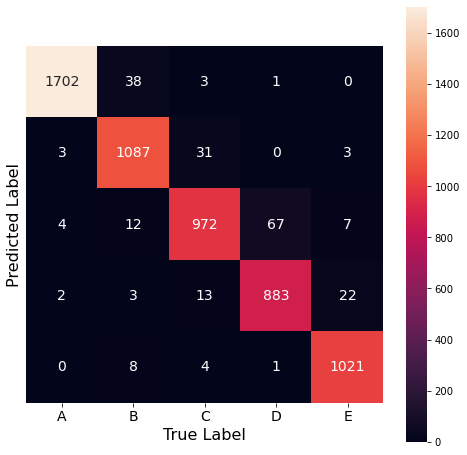

In [39]:
# Además, podemos representar estos resultados de forma gráfica en una matriz de confusión:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize = (8,8))
labels = sorted(y_test.unique().tolist())

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = True, 
            xticklabels = labels, yticklabels = [], ax = ax, 
            cbar_kws={"orientation": "vertical"}, annot_kws={"size": 14}).set_xticklabels(labels, fontsize = 14)

plt.xlabel('True Label'     , fontsize = 16)
plt.ylabel('Predicted Label', fontsize = 16);

### 3.6. ARTIFICIAL NEURAL NETWORKS (ANN): MLPClassifier.

In [40]:
from sklearn.metrics        import classification_report
from sklearn.neural_network import MLPClassifier

# Definición del modelo y entrenamiento:
mlp = MLPClassifier(solver = 'adam', 
                    alpha = 0.0001, 
                    random_state = None, 
                    verbose = False, 
                    learning_rate_init = 0.001,
                    learning_rate = 'constant', 
                    hidden_layer_sizes = (128, 128, 5),
                    activation = 'relu', 
                    max_iter = 200)
mlp.fit(X_train, y_train)

# Validación del modelo:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A'     , 'True B'     , 'True C'     , 'True D'     , 'True E']
)
print(conf)

              precision    recall  f1-score   support

           A       0.98      0.98      0.98      1711
           B       0.96      0.92      0.94      1148
           C       0.89      0.94      0.91      1023
           D       0.93      0.93      0.93       952
           E       0.97      0.96      0.97      1053

    accuracy                           0.95      5887
   macro avg       0.95      0.95      0.95      5887
weighted avg       0.95      0.95      0.95      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1679           17            8            7            0
True B           31         1057           42            8           10
True C            0           23          960           38            2
True D            1            0           46          888           17
True E            0            5           22           17         1009


In [41]:
# ESTUDIO DEL SOBREAJUSTE (OVERFITTING):

# Accuracy para el dataset de entrenamiento:
y_pred_train = mlp.predict(X_train)
print('ACCURACY PARA DATASET DE TRAINING:')
print(classification_report(y_train, y_pred_train))

# Accuracy para el dataset de validación:
y_pred_test  = mlp.predict(X_test)
print('ACCURACY PARA DATASET DE TEST:')
print(classification_report(y_test, y_pred_test))

ACCURACY PARA DATASET DE TRAINING:
              precision    recall  f1-score   support

           A       0.98      0.99      0.99      3869
           B       0.98      0.95      0.97      2649
           C       0.94      0.96      0.95      2399
           D       0.96      0.96      0.96      2264
           E       0.99      0.98      0.99      2554

    accuracy                           0.97     13735
   macro avg       0.97      0.97      0.97     13735
weighted avg       0.97      0.97      0.97     13735

ACCURACY PARA DATASET DE TEST:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98      1711
           B       0.96      0.92      0.94      1148
           C       0.89      0.94      0.91      1023
           D       0.93      0.93      0.93       952
           E       0.97      0.96      0.97      1053

    accuracy                           0.95      5887
   macro avg       0.95      0.95      0.95      5887
weighted av

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;MODELO BIEN AJUSTADO: DIFERENCIA DE AUC ENTRE CONJUNTO TRAIN Y TEST IGUAL A 0,02.</h4></font>

In [42]:
# AJUSTE DE PARÁMETROS:
# alpha             : L2 penalty (regularization term) parameter.
# hidden_layer_sizes: the ith element represents the number of neurons in the ith hidden layer.

tuned_parameters={'alpha'             : [     1e-4,      1e-6,        1e-8],
                  'hidden_layer_sizes': [(32,32,5), (64,64,5), (128,128,5)]}

doGridSearch(MLPClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, 
             ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
             ['True A', 'True B', 'True C', 'True D', 'True E'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'alpha': 1e-06, 'hidden_layer_sizes': (128, 128, 5)}

Grid scores on development set:

0.844 (+/-0.069) for {'alpha': 0.0001, 'hidden_layer_sizes': (32, 32, 5)}
0.917 (+/-0.059) for {'alpha': 0.0001, 'hidden_layer_sizes': (64, 64, 5)}
0.939 (+/-0.060) for {'alpha': 0.0001, 'hidden_layer_sizes': (128, 128, 5)}
0.844 (+/-0.076) for {'alpha': 1e-06, 'hidden_layer_sizes': (32, 32, 5)}
0.923 (+/-0.034) for {'alpha': 1e-06, 'hidden_layer_sizes': (64, 64, 5)}
0.950 (+/-0.029) for {'alpha': 1e-06, 'hidden_layer_sizes': (128, 128, 5)}
0.871 (+/-0.040) for {'alpha': 1e-08, 'hidden_layer_sizes': (32, 32, 5)}
0.924 (+/-0.039) for {'alpha': 1e-08, 'hidden_layer_sizes': (64, 64, 5)}
0.881 (+/-0.402) for {'alpha': 1e-08, 'hidden_layer_sizes': (128, 128, 5)}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precisio

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(128, 128, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

<img src="./imgs/ok.png" align="left" style="float" width="35">
<font color="green"><h4>&nbsp;&nbsp;DISMINUYENDO EL PARÁMETRO DE PENALIZACIÓN Y AUMENTANDO EL NÚMERO DE NEURONAS POR CAPA SE PUEDE MEJORAR LA AUC.</h4></font>

### 3.7. ARTIFICIAL NEURAL NETWORKS (ANN) con Keras y Tensorflow.

In [63]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# PARA PODER TRABAJAR CON EL PAQUETE keras NECESITAMOS QUE LOS VALORES DE LA VARIABLE target SEAN NUMÉRICOS:
df['TARGET'] = df['TARGET'].astype('category')
df['TARGET'] = df['TARGET'].cat.codes

# DIVIDIMOS EL DATASET:
X = df.iloc[:,range(0,32)]
Y = df.iloc[:,32]

# NORMALIZAMOS LOS VALORES DE LAS VARIABLES PREDICTORAS:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)

# PARA UTILIZAR EL DATASET CON VALORES NORMALIZADOS:
X = scaled_X.copy()

# OBTENEMOS LOS SUBCONJUNTOS DE ENTRENAMIENTO Y VALIDACIÓN:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [65]:
import keras

from keras.models import Sequential
from keras.layers import Dense

# DEFINICIÓN DEL MODELO SECUENCIAL:
# - Número de capas: 5
# - Neuronas en la capa de entrada = número de predictores (32)
# - Neuronas en la capa de salida  = número de clases de la variable target (5)
# - Función de activación: relu

model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape=(32,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense( 5, activation = 'softmax'))
model.summary()

# ENTRENAMIENTO Y VALIDACIÓN DEL MODELO:
model.compile(loss      = 'sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics   = ['accuracy'] 
              )
model.fit(X_train, y_train, epochs = 50, verbose = 1, validation_data = (X_test, y_test))

# Evaluación del modelo:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss:    ', score[0])
print('Test Accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 325       
Total params: 11,813
Trainable params: 11,813
Non-trainable params: 0
_________________________________________________________________
Train on 13735 samples, validate on 5887 samples
Epoch 1/50
13735/13735 [==============================] - 1s 55us/s

In [45]:
from sklearn.metrics import classification_report

# Validación del modelo contra el dataset de test:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

# Matriz de confusión:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred),)
print(conf)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1711
           1       0.88      0.80      0.84      1148
           2       0.77      0.86      0.81      1023
           3       0.86      0.79      0.82       952
           4       0.81      0.93      0.87      1053

    accuracy                           0.87      5887
   macro avg       0.86      0.86      0.86      5887
weighted avg       0.87      0.87      0.87      5887

      0    1    2    3    4
0  1585   65   26   26    9
1    27  922   79   31   89
2     3   39  879   28   74
3     3   10  126  751   62
4     0    8   27   37  981


### 3.8. EASTER EGG: NAIVE-BAYES (Gaussian/Multinomial).

In [46]:
# NAIVE-BAYES:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

nb1 = GaussianNB(var_smoothing = 1e-03) # var_smoothing=0.001 OBTENIDO DESPUÉS DE REALIZAR UN AJUSTE DE PARÁMETROS CON LA FUNCIÓN doGridSearch.
nb2 = MultinomialNB(alpha = 0.1)        # alpha=0.1 OBTENIDO DESPUÉS DE REALIZAR UN AJUSTE DE PARÁMETROS CON LA FUNCIÓN doGridSearch.

In [47]:
nb1.fit(X_train, y_train)

y_pred1 = nb1.predict(X_test)

print(classification_report(y_test, y_pred1))

conf = pd.DataFrame(confusion_matrix(y_test, y_pred1), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
                   )
print(conf)

              precision    recall  f1-score   support

           0       0.83      0.57      0.67      1711
           1       0.55      0.50      0.52      1148
           2       0.41      0.68      0.51      1023
           3       0.41      0.46      0.43       952
           4       0.59      0.51      0.54      1053

    accuracy                           0.54      5887
   macro avg       0.56      0.54      0.54      5887
weighted avg       0.59      0.54      0.55      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A          967          153          300          222           69
True B          112          572          252          127           85
True C           45          117          691           98           72
True D           20           52          293          437          150
True E           23          143          161          194          532


In [48]:
nb2.fit(X_train, y_train)

y_pred2 = nb2.predict(X_test)

print(classification_report(y_test, y_pred2))

conf = pd.DataFrame(confusion_matrix(y_test, y_pred2), 
                    columns = ['Predicted A', 'Predicted B', 'Predicted C', 'Predicted D', 'Predicted E'], 
                    index   = ['True A', 'True B', 'True C', 'True D', 'True E']
                   )
print(conf)

              precision    recall  f1-score   support

           0       0.31      0.93      0.47      1711
           1       0.24      0.09      0.13      1148
           2       0.00      0.00      0.00      1023
           3       0.63      0.11      0.18       952
           4       0.43      0.07      0.12      1053

    accuracy                           0.32      5887
   macro avg       0.32      0.24      0.18      5887
weighted avg       0.31      0.32      0.21      5887

        Predicted A  Predicted B  Predicted C  Predicted D  Predicted E
True A         1590           99            2            0           20
True B          986          106            0           14           42
True C         1004            9            0            0           10
True D          686          135            0          101           30
True E          827          102            1           46           77


<img src="./imgs/warning.jpg" align="left" style="float" width="35">
<font color="red"><h4>&nbsp;&nbsp;EN BASE A ESTOS RESULTADOS, PARECE QUE ESTE MODELO NO ES ADECUADO PARA ENTRENAR EL DATASET DE REFERENCIA.</h4></font>

## 4. RESUMEN: COMPARATIVA ENTRE MODELOS DE APRENDIZAJE SUPERVISADO.

In [56]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# DIVIDIMOS EL DATASET:
X = df.iloc[:,range(0,32)]
Y = df.iloc[:,32]

# NORMALIZAMOS LOS VALORES DE LAS VARIABLES PREDICTORAS:
scaler   = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns = X.columns)

X = scaled_X.copy()

# OBTENEMOS LOS SUBCONJUNTOS DE ENTRENAMIENTO Y VALIDACIÓN:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

CART: 0.956886 (0.008685)
RF  : 0.995414 (0.004232)
GBT : 0.956019 (0.011125)
KNN : 0.969066 (0.008508)
SVM : 0.897358 (0.014556)
MLP : 0.918614 (0.013716)


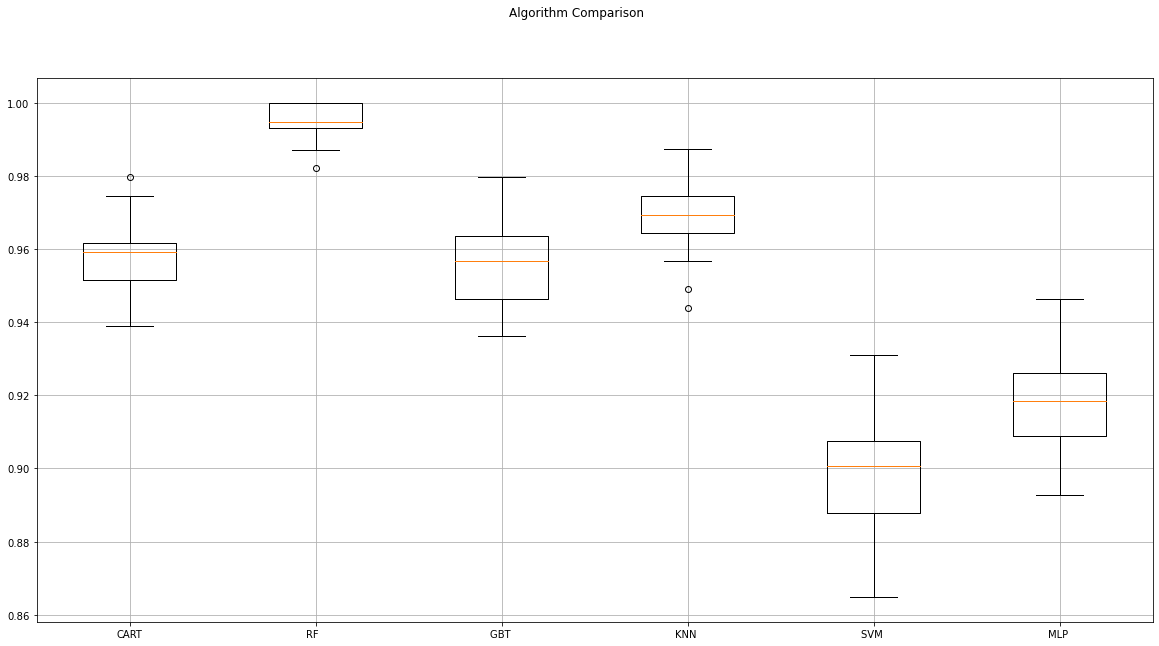

In [57]:
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier

seed = 9

models = []
models.append(('CART', DecisionTreeClassifier    ()))
models.append(('RF  ', RandomForestClassifier    ()))
models.append(('GBT ', GradientBoostingClassifier()))
models.append(('KNN ', KNeighborsClassifier      ()))
models.append(('SVM ', SVC                       ()))
models.append(('MLP ', MLPClassifier             ()))

results = []
names   = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits = 50, random_state = seed, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.set_size_inches(20, 10)
fig.suptitle('SUPERVISED LEARNING ALGORITHM COMPARISON')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid(True)
plt.show()